# Univariate Exploratory Data Analysis
---
## Purpose:
In the last notebooks (Data_manipulation & Basic_data_structure) we established functions to enable us to drill down and characterize emissions at the county or state level, as well as by emission sector. <u>In this notebook, we will explore basic trends that we see in the initial datasets exclusively.</u> In the next notebook we will explore multivariate trends or correlations.   


### Package Installation and Versioning Requirments:
For questions regarding python version, package installations, and other functional requirements, see the *Read Me* file contained [here](link).

Now, let's begin.

### Import Packages and Load Data

In [130]:
#importing required packages: 
import matplotlib.pyplot as plt 

# Importing py files
from Basic_data_structure import *
from Data_manipulation import *

# Load the dataframes
global df_emissions, df_USDA, df_Redfin
df_emissions, df_USDA, df_Redfin = load_base_data()

# Clean the county-level dataframes, focusing on residential emissions
df_Redfin_County = Clean_Redfin(df_Redfin, "COUNTY")
df_USDA_County = Clean_USDA(df_USDA, "COUNTY")
df_emissions_County = Clean_EPA(df_emissions, "COUNTY", "residential", agg=True)

# Clean the state-level dataframes, focusing on residential emissions
df_Redfin_State = Clean_Redfin(df_Redfin, "STATE")
df_USDA_State = Clean_USDA(df_USDA, "STATE")
df_emissions_State = Clean_EPA(df_emissions, "STATE", "residential", agg=True)

#Get Merged Dataframes to work with 
df_merged_state = get_merge_df(df_emissions_State,df_USDA_State,df_Redfin_State, level="STATE")
df_merged_cty = get_merge_df(df_emissions_County,df_USDA_County,df_Redfin_County, level="COUNTY")

### Univariate Analysis of Cleaned Datasets

#### Histograms

In [131]:
# We're going to start with a few plotting functions to help us understand univariate distributes. It's important to 
# first know how each of our features that we're interested in are skewed across the dataframes.

# So, let's start by plotting histograms of income, pollution, home prices, and unemployment rates. 
# For pollution, we really shoudl consider a normalized basis, and we will in our merged data analysis, but for now 
# let's just consider the cumulative distributions across states -- without respect to population.

In [132]:
def hist_plot_base (bin_list, level="STATE"):
    """This function creates 4 histograms to evaluate the distribution of income, property values, unemployment, and 
    aggregate residential emissions at either the state level or the county county."""
    
    if level == "STATE": 
        df1, df2, df3, df4 = df_USDA_State, df_Redfin_State, df_USDA_State, df_emissions_State
    elif level == "COUNTY":
        df1, df2, df3, df4 = df_USDA_County, df_Redfin_County, df_USDA_County, df_emissions_County        
          
    dfs = [df1, df2, df3, df4]
    
    #Set the figure object, while providing a numpy array of axis (our 2x2 matrix)
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    titles = ["Income", "Property Value", "Unemployment Rates", "Emissions"]
    xlabels = ["USDx1k", "USDx100k", "Percent", "TPYx100k"]
    colors = ['skyblue', 'salmon', 'lightgreen', 'gold']
    columns = ["Median_Household_Income_2021", "median_sale_price", "Unemployment_rate_2021", "EMISSIONS"]
    divisor = [1e3, 1e5, 1, 1e5]
    
    # We're going to iterate through each of the 4 dataframes, and assign the proper title, label, coloring, and 
    # scaling factor using the zip method on our flattened list of subplots. 
    for ax, df, title, xlabel, bins, color, column, div in zip(axs.flat, dfs, titles, xlabels,
                                                               bin_list, colors, columns, divisor):
        ax.hist(df[column] / div , bins=bins, color=color, edgecolor='black')
        ax.set_title(f'Distribution of {title}')
        ax.set_ylabel('Count')
        ax.set_xlabel(xlabel)
        if level=="COUNTY" and title == "Emissions": 
            axs[1, 1].set_xlim(0, 0.6)
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    # Show plot
    plt.show()


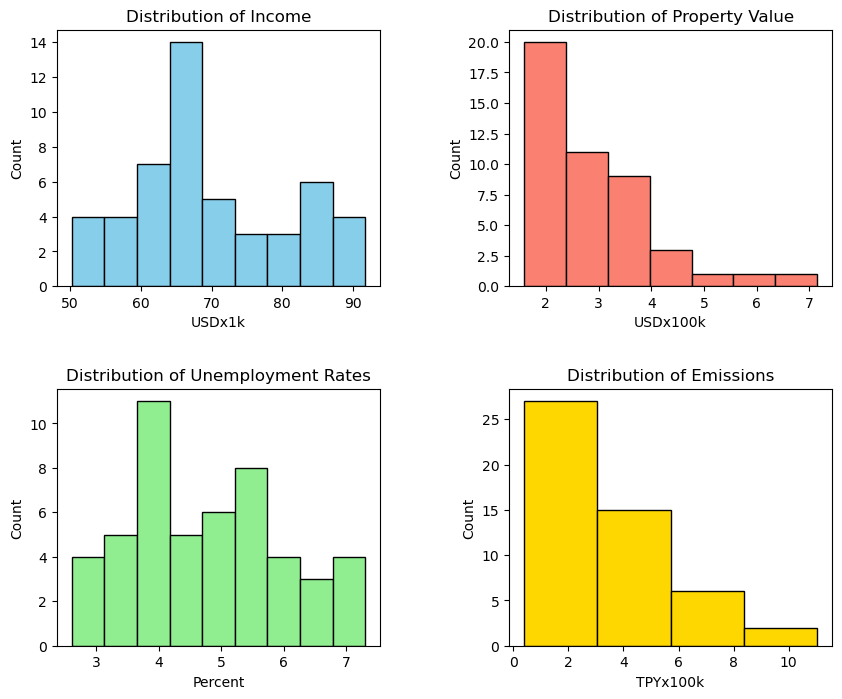

In [133]:
state_bins = [9, 7, 9, 4]
hist_plot_base(state_bins, "STATE")

In [134]:
# From generating the histogram plots for income, property values, unemployment, and emissions we learn a few things
# about the data. First, home prices are right-tailed, meaning that average home prices are going to significantly 
# exceed the median due to the outliers that purchase really expensive properties. 

# Also, when we consider aggregate emissions, not normalized to population we also see a decent right tail, and 
# this makes sense when we consider some states like California and Texas have much greater populations than states
# like Alaska, where residential emissions will be pretty low. 

# As for income, you might be inclined to think it follows a normal distribution (with bin=4), but if we expand our 
# bin size you should notice the outer tails on both sides don't seem to taper. In fact, it seems the right tail 
# becomes pretty apparent when we increase the bin size to around 19.

# Finally, unemployment at the state level seems generally grounded around 4%. We do see some higher and lower 
# values, and when we plot this spatially in a choropleth, we'll get to see what the distribution looks like 
# across the US. 

# Let's examine now at the county level.

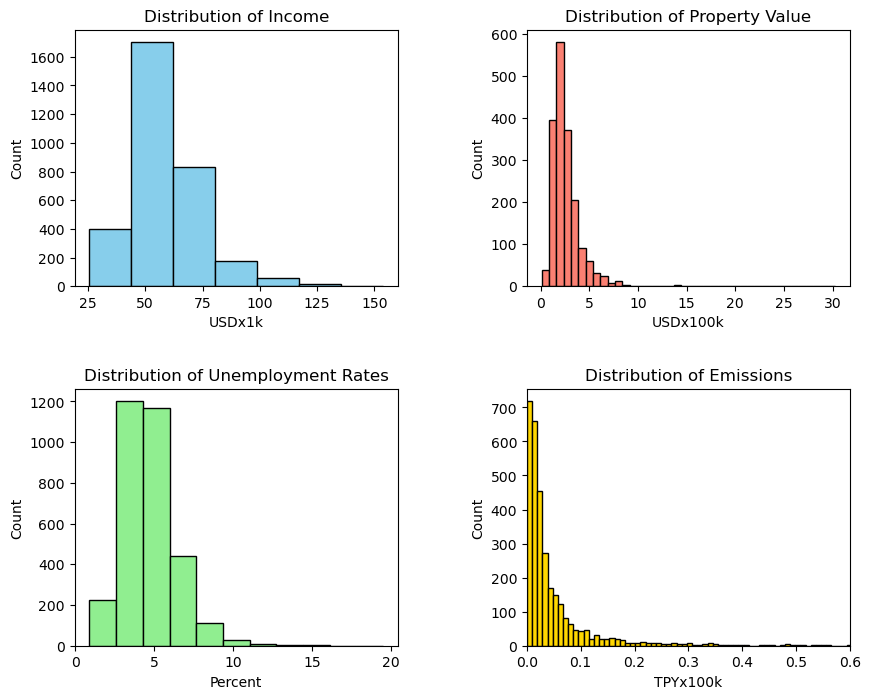

In [135]:
county_bins = [7, 40, 11, 200]
hist_plot_base(county_bins, "COUNTY")

In [129]:
# So what's interesting here at the county level, is that we see exactly why it's so important to normalize pollution
# to our population size. The vast majority of counties have a around 10 tons per year of pollution, but larger counties
# that host massive populations (like LA, Las Vegas, and NYC) are so out on the map that you can't observe them on 
# the axis of this scale. The same can be said for property values which are skewed in some counties to the millions of 
# dollars. 


In [160]:
# It might also be helpful to get a quick snapshot of how these variables are distinct between the top 5 and 
# bottom 5 states. Let's load a couple functions to dive into that now.  


def get_extremes(df, column): 
    """filter dataframe to the top 5 and lowest five entries. We'll do this by creating a copy of the original"""
    top_vals = df.nlargest(5, column)
    bot_vals = df.nsmallest(5, column)

    # bring the two back together for our top and bottom 5
    output_df = pd.concat([top_vals, bot_vals])
    return(output_df)


def bar_plotter(dfs):
    
    # Set the figure object, while providing a numpy array of axis (our 2x2 matrix)
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    titles = ["Income", "Property Value", "Unemployment Rate", "Emission"]
    ylabels = ["USDx1k", "USDx100k", "Percent", "TPYx100k"]
    colors = ['skyblue', 'salmon', 'lightgreen', 'gold']
    columns = ["Median_Household_Income_2021", "median_sale_price", "Unemployment_rate_2021", "EMISSIONS"]
    divisor = [1e3, 1e5, 1, 1e5]
    states = ["State", "state_code", "State", "STATE"]
    # We're going to iterate through each of the 4 dataframes, and assign the proper title, label, coloring, and 
    # scaling factor using the zip method on our flattened list of subplots. 
    for ax, df, title, ylabel, color, column, div, state in zip(axs.flat, dfs, titles, ylabels,
                                                         colors, columns, divisor, states):
        #set indices for the states (our x range)
        indices = np.arange(len(df)) 
        ax.bar(indices, df[column] / div, color=color, edgecolor='black') 
        # Set x-ticks at bar positions
        ax.set_xticks(indices)  
        # Set x-tick labels to the state
        ax.set_xticklabels(df[state])  
        ax.set_title(f'Comparison of Top and Bottom 5: {title}s')
        ax.set_ylabel(ylabel)
        ax.set_xlabel("State")
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    


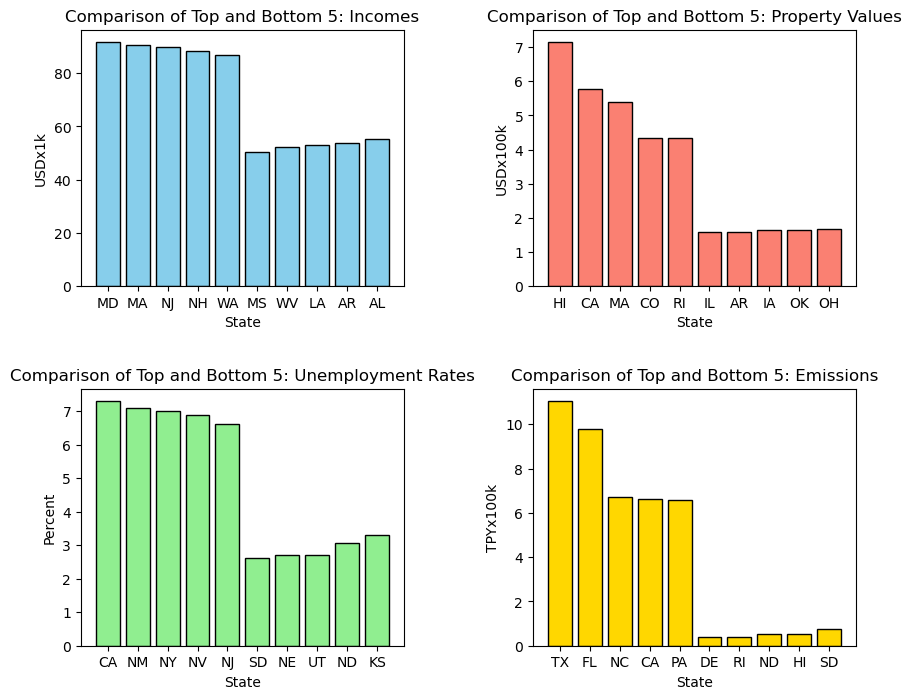

In [161]:
dfs = [df_USDA_State, df_Redfin_State, df_USDA_State, df_emissions_State]
columns = ["Median_Household_Income_2021", "median_sale_price", "Unemployment_rate_2021", "EMISSIONS"]

top_bot_dfs = [get_extremes(df, column) for df, column in zip(dfs, columns)]

bar_plotter(top_bot_dfs)

In [ ]:
# So this gives us a nice overview of some key differences between our most extreme states for income, property value, 
# unemployment, and emissions. It's worth pointing out that top incomes don't actually seem to trend that well with 
# property values. In fact, only one of the top and bottom 5 states appear to exist on both plots (Massachuessetts)

# Emissions, cumulated by state, seem to appear much higher for larger states, than the smaller ones like Delaware and
# Rhode island, and for higher populations (like Texas vs. South Dakota). To really probe this though we should 
# normalize by population, and we're going to do that in our next set of analysis. 

### Preface for Multi-Variate Analysis 
Now for this project, we're really trying to answer questions like: 
1. Are factors of wealthy, population density, and inequality correlated with pollution levels?
2. Which areas generate the greatest residental pollution relative to local income? 
3. Which regions have the greatest residental pollution relative to their property values? 
4. How are pollution compositions stratified across sectors when we look at different groups of people? 

To do that, we need to do multi-variate analysis on the merged dataframe. So our next set of data manipulation and plotting functions are going to focus on how the variables like location, income, pollution, and property values intertwine. Let's start with the simplest questions (2 & 3) which focus on finding the regions with largest pollution to income or property value ratios. 

Since we're going to spend a bit of time on this, we're going to begin the work on a new notebook. 

### End of Notebook

Next notebook: Multivariate Analysis 

---